In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spkit as sp

train_csv = pd.read_csv('0_0.csv')

In [5]:
#subset first 1 second of data to make the wave legible
train_data = train_csv.iloc[:,0:5000]
train_data = train_data.to_numpy().flatten()
train_data = train_data

#apply butterworth filter to smooth raw data
train_data_filtered = sp.filter_X(train_data,band=[0.5,200], btype='bandpass',fs=500,verbose=0)

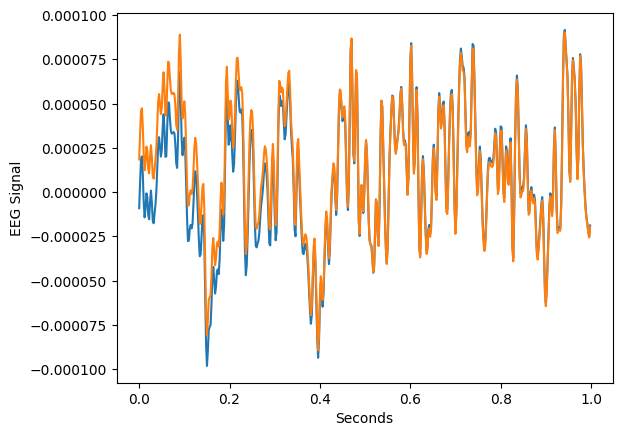

In [6]:
#plot unfiltered vs. filtered (aka smoothed) data
plt.plot(np.arange(0,1,1/500),train_data[:500]) #blue
#np.arange gets increments of 0.02 seconds to use as x-vals in plotting the EEG readings (there are 500 readings per second)
plt.plot(np.arange(0,1,1/500),train_data_filtered[:500]) #orange
plt.ylabel('EEG Signal')
plt.xlabel('Seconds')
plt.show()

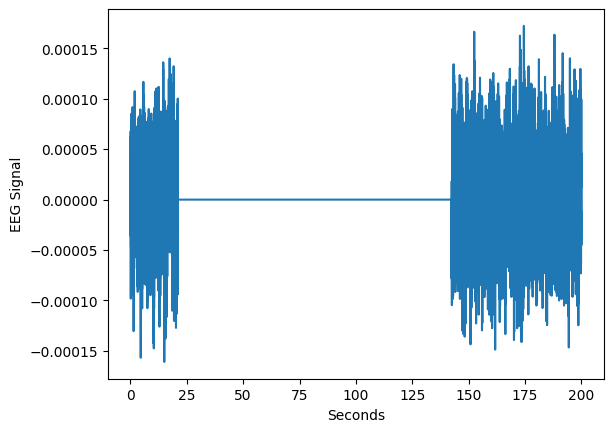

In [7]:
#subset first 200 seconds of data
first_200 = train_data[:100000]
seconds = np.arange(0,200,1/500)

#plot missing data to show shortcomings in collection method
plt.plot(seconds,first_200)
plt.ylabel('EEG Signal')
plt.xlabel('Seconds')
plt.show()

In [8]:
#reshape data into orginal form: 1 row = 5000 observations (500 observations/s for 10s) = 1 epoch
train_data_reshape = train_data_filtered.reshape(-1,5000)

In [ ]:
#create an array of frequencies for the component waves that a Fourier transform splits the filtered wave into
fs = 500     
epoch_len = 5000
wave_frequency = np.fft.rfftfreq(epoch_len, 1.0/fs)

#biologicially significant intervals for rat brainwaves
rat_eeg_bins = {'Delta': (1, 4),
                'Theta': (5, 9),
                'Alpha': (10, 15),
                'Beta': (16, 30),
                'Gamma': (31, 48),
                'High Gamma': (52, 95),
                'HFO': (105, 200)}


mean_amplitudes = []
for epoch in train_data_reshape:
    #split smoothed wave into its component waves with a Fourier transform and get amplitude of each component wave (performing this operation epoch by epoch)
    wave_amplitudes = np.absolute(np.fft.rfft(epoch))

    #record mean amplitude of all rat brainwaves which fall into each biologically significant bin
    epoch_mean_amplitudes = []
    for bin in rat_eeg_bins:  
        #select bin interval
        bin_lower_limit = rat_eeg_bins[bin][0]
        bin_upper_limit = rat_eeg_bins[bin][1]
        #select the amplitudes for all waves that fall in this frequency bin
        freq_ix = np.where((wave_frequency >= bin_lower_limit) & 
                        (wave_frequency <= bin_upper_limit))
        freq_ix = freq_ix[0]
        #average amplitudes and record
        avg = np.mean(wave_amplitudes[freq_ix])
        epoch_mean_amplitudes.append(avg) 
    
    #record each bin's mean amplitude for every epoch
    mean_amplitudes.append(epoch_mean_amplitudes)

Text(0, 0.5, 'Mean band Amplitude')

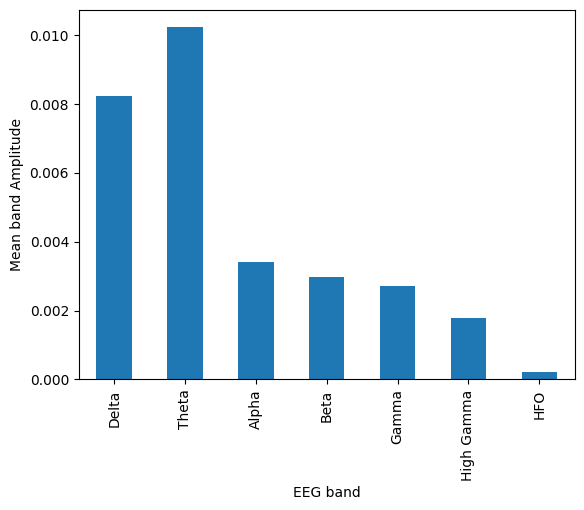

In [23]:
#convert one epoch of average amplitudes into a datafame
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = rat_eeg_bins.keys()
df['val'] = mean_amplitudes[2000]
#plot this one observation as a barchart to visualize for presentation
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")